# Review: Complex Queries

* Restriction by a query (Subquery in the `WHERE` clause)
* Join
    - Cross join
    - Inner join
    - Equijoin
    - Natural join
* Aggregation  
    * `LEFT JOIN` followed by `GROUP BY`

# Relational Division

Relational division is a query of the type: 
> "Find all entries in A that have a mathcing entry in B for each entry in C."

For example, imagine you have a database for managing the hiring pipeline for a company. You have Tables `Candidate` and `CandidateSkill` listing all employees' skills. Then you have a table `Job` and `RequiredSkills`. 

You are now asked to
> "Show all the candidates who qualify for a given job."

Examples from other databases could be:
> "Find all students who have completed all the required courses for their major."
> "Find all students who have completed all the required courses for their major."
> "Show all airlins that every 

This is not a trivial query with no direct support in DataJoint and SQL. There are several ways to solve it. I will illustrate just one. You can search for other articles on relational division to review other approaches.

In [1]:
import datajoint as dj
from faker import Faker
fake = Faker()

In [2]:
schema = dj.Schema('dimitri_hiring')
schema.drop()
schema = dj.Schema('dimitri_hiring')

[2022-10-18 23:58:27,572][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-10-18 23:58:28,453][INFO]: Connected dimitri@db.ust-data-sci.net:3306


Proceed to delete entire schema `dimitri_hiring`? [yes, No]: yes


In [4]:
@schema
class Skill(dj.Lookup):
    definition = """
    skill : varchar(24)
    """
    contents = zip(
        ("SQL", "Java", "Python", "C++", 
         "JavaScript", "R", "Rust"))

In [5]:
Skill()

skill
C++
Java
JavaScript
Python
R
Rust
SQL


In [7]:
@schema
class Candidate(dj.Manual):
    definition = """
    candidate_id : int
    ---
    name  : varchar(60)
    """
    
    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [8]:
Candidate.insert(((fake.random_int(), fake.name()) for _ in range(300)), 
                 skip_duplicates=True)

In [9]:
Candidate()

candidate_id,name
10,Kristine Cruz
49,Kathy Weeks
140,John Moreno
155,Sierra Herrera
165,Tiffany Hernandez
232,Leslie Lopez
254,Julia Taylor
266,Nicole Allen
287,John Hill
311,Dr. Tammy Anderson


In [11]:
Candidate * Skill & 'rand() < 0.4'

candidate_id,skill,name
10,R,Kristine Cruz
49,JavaScript,Kathy Weeks
49,Rust,Kathy Weeks
49,SQL,Kathy Weeks
140,Java,John Moreno
140,Python,John Moreno
140,R,John Moreno
140,Rust,John Moreno
155,SQL,Sierra Herrera
165,Rust,Tiffany Hernandez


In [12]:
Candidate.Skill.insert(
    Candidate.proj() * Skill & 'RAND() < 0.4')

In [13]:
Candidate.Skill()

candidate_id,skill
10,Java
10,JavaScript
10,R
10,Rust
10,SQL
49,Python
49,R
49,SQL
140,C++
140,Java


In [14]:
@schema
class Position(dj.Manual):
    definition = """
    position : varchar(12)   
    ---
    position_description : varchar(60)
    """

    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [15]:
Position.insert1(("SWE1", "Software Engineer I"))
Position.Skill.insert((
    ("SWE1", "Rust"),
    ("SWE1", "JavaScript"),
    ("SWE1", "Java")))

In [16]:
Position.insert1(("DS2", "Data Scientist II"))
Position.Skill.insert((
    ("DS2", "SQL"),
    ("DS2", "Python")))

In [17]:
Position.Skill()

position,skill
DS2,Python
DS2,SQL
SWE1,Java
SWE1,JavaScript
SWE1,Rust


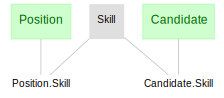

In [18]:
dj.Diagram(schema)

# Query example

In [25]:
Candidate & (Candidate.Skill() & 'skill = "Java"') \
& (Candidate.Skill() & 'skill = "Python"')

candidate_id,name
140,John Moreno
314,Thomas Cruz
384,Pamela Morrow
655,George Martin
1184,James Hopkins
1654,Justin Ewing
1729,Daniel Williams
2320,Amy Wilson
2387,Melissa Richardson
2515,Anthony Durham


In [26]:
# All candidates who have the required skill

cpp_experts = Candidate & (Candidate.Skill & {"skill": 'C++'})
cpp_experts

candidate_id,name
140,John Moreno
266,Nicole Allen
287,John Hill
314,Thomas Cruz
381,Chris Torres
384,Pamela Morrow
474,Jamie King
583,Christopher Hughes
622,John George
825,Jared Underwood


### Show candidates who qualify for a given job

Rephrase (position)

> Show candidates who have *all* the skills required for job "SWE1"

Rephrasing (a double negative)

> Show candidates for whom there is no skill required for job "SWE1" that she does not possess.


In [27]:
# skills for SWE1
required_skill = Position.Skill() & {'position': "SWE1"}
required_skill

position,skill
SWE1,Java
SWE1,JavaScript
SWE1,Rust


In [33]:
Candidate - (Candidate().proj() * required_skill - Candidate.Skill())

candidate_id,name
10,Kristine Cruz
140,John Moreno
155,Sierra Herrera
423,Aaron Orozco
1624,Justin Wallace
1656,Troy Allen DDS
1978,Jody White
2164,Rhonda Smith
2387,Melissa Richardson
2515,Anthony Durham


In [29]:
Candidate.Skill()

candidate_id,skill
10,Java
10,JavaScript
10,R
10,Rust
10,SQL
49,Python
49,R
49,SQL
140,C++
140,Java


In [ ]:
# candidates' missing skills
missing_skill = Candidate.proj() * required_skill - Candidate.Skill
missing_skill

In [ ]:
# qualified candidates
qualified_candidate = Candidate - missing_skill
qualified_candidate

In [ ]:
# Candidates who qualify for job SWE1

Candidate - (
    (Candidate.proj() * Position.Skill & {'position': "SWE1"})
    - Candidate.Skill)

## SQL equlvalent

Literal translation of the above DataJoint query
```sql
USE dimitri_hiring;

SELECT candidate_id, name 
FROM candidate 
WHERE candidate_id NOT IN (
    SELECT candidate_id
    FROM candidate NATURAL JOIN position__skill
    WHERE position = "SWE1" AND (candidate_id, skill) NOT IN (
        SELECT candidate_id, skill FROM candidate__skill))
```

## Using Aggregation

Another method is to simply compare the number of matching skils for each candidate to the total number of matching skills, using aggregation.

In [ ]:
Candidate()

In [ ]:
Candidate.Skill() * Position.Skill() & {'position': 'SWE1'}

In [ ]:
qualified = Candidate.aggr(
    Candidate.Skill * Position.Skill & {'position': "SWE1"}, 
     n='count(skill)') & 'n=3'

qualified

## SQL equivalent

```sql
SELECT candidate_id, name 
FROM candidate NATURAL JOIN 
     candidate__skill NATURAL JOIN position__skill
WHERE position="SWE1" 
GROUP BY candidate_id 
HAVING n=3
```